In [1]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
import utils
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import LSE_net
import importlib
from DatasetGenerator import generate_dataset, torchFLPO_2_numpyFLPO
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D
import Animator
from pathlib import Path
import GD
import ModelPass as mp
import inference
from Anneal import anneal

In [2]:

seed=0;
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
print("Running on: " , device)


Running on:  cpu


### Initialize an FLPO scenario

Run the below command if you encounter errors running the plotting block.

In [3]:
# !pip install nbformat --upgrade


In [4]:
num_drones = 20
n_drone_clusters = 10
drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
num_facilities = 50
num_distinct_ends = 2
dim_ = 2
print(f"num_drones = {num_drones}\tnum_facilities = {num_facilities}\tdim = {dim_}")

START_locs, F_base, END_locs = generate_dataset(
    num_drones, n_drone_clusters, drone_cluster_split, num_facilities, dim_, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1,num_distinct_ends=num_distinct_ends
)
np_flpo_filename = 'numpy_FLPO_data/numpy_FLPO_data'
torchFLPO_2_numpyFLPO(START_locs, END_locs, F_base, np_flpo_filename, scale=1.0)

# plot_UAV_FLPO(START_locs, END_locs, F_base)
# plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

num_drones = 20	num_facilities = 50	dim = 2
Data Created.


### Load the VRP NET Module

In [5]:
torch.cuda.empty_cache()
model_classes = {"VRPNet_L": VRPNet_L}
weights_address = (
    Path("Saved_models") /
    "VRPNet_L_lr1e-04_bs32_ep60000_samples1920000_cities50_inputdim2_"
    "workers0_hidden64_enc1_dec1_heads8_dropout0.30_"
    "train_PO_2025_05_17_22_43_32last_model.pth"
)
vrp_net = utils.load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in vrp_net.parameters():
    param.requires_grad = False
print("VRP NET loaded on: ", vrp_net.device)
print(summary(vrp_net))

Model created.
VRP NET loaded on:  cpu
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,048
│    └─ModuleList: 2-1                                                 --
│    │    └─MultiheadAttention: 3-1                                    (66,048)
│    │    └─MultiheadAttention: 3-2                                    (66,048)
│    │    └─MultiheadAttention: 3-3                                    (66,048)
│    │    └─MultiheadAttention: 3-4                                    (66,048)
│    │    └─MultiheadAttention: 3-5                                    (66,048)
│    │    └─MultiheadAttention: 3-6                                    (66,048)
│    └─ModuleList: 2-2                                                 --
│    │    └─MultiheadAttention: 3-7                                    (66,048)
│    │    └─MultiheadAt

### Load the LSE net module

In [6]:
importlib.reload(LSE_net)
lse_data = torch.load('logSumExp_models/lse_2025_5_19__15_47_58.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
io_scale = lse_data['io_scale']
D_max_range = lse_data['D_max_range']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'D_max_scale: {D_max_range}\nn_inputs: {n_inputs}\nn_outputs: {n_outputs}\nlayers: {layers}\nio_scale: {io_scale}\nLSE_net:\n{summary(lse_net)}')

D_max_scale: 5.0
n_inputs: 3
n_outputs: 1
layers: [20, 20, 10]
io_scale: 1
LSE_net:
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (420)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (210)
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (11)
Total params: 721
Trainable params: 0
Non-trainable params: 721


### Optimization loop for a single beta
Warning: Use $\beta >= 1e-3$, as the free energy approximation is poor for $\beta < 5e-4$ with torch.float32 datatype.

In [8]:
optim_iters = 200
optim_step = 0.01
b_min = 1e-3
beta = 1e3
tol = 1e-3

# Y_arr, FreeEnergy, G = GD.Adam_at_beta(
#     F_base, START_locs, END_locs, vrp_net, lse_net, optim_iters,
#     optim_step, b_min, beta, D_max_range=D_max_range, tol=tol, allowPrint=True, return_list= True)

# F_base, FreeEnergy, G = GD.GD_at_beta1(
#     F_base, START_locs, END_locs, vrp_net, lse_net, optim_iters, 
#     optim_step, b_min, beta, D_max_range=D_max_range, tol=tol, allowPrint=True)

# F_base, FreeEnergy, G = GD.GD_at_beta0(
#     F_base, START_locs, END_locs, vrp_net, lse_net, optim_iters, 
#     optim_step, b_min, beta, D_max_range=D_max_range, tol=tol, allowPrint=True)

F_base, FreeEnergy, G = GD.sampling_GD_at_beta(
    F_base,
    START_locs,
    END_locs,
    vrp_net,
    n_path_samples=20,
    beta=1e3,
    stepsize=0.1,
    iters=100,
    tol=1e-3,
    allowPrint=True
    )

n_drones:20	num_facilities:50	dim_:2
iter: 0	FreeE:0.077	Norm gradient: 0.208	mean_D_min:7.660e-02
iter: 1	FreeE:0.072	Norm gradient: 0.190	mean_D_min:7.241e-02
iter: 2	FreeE:0.069	Norm gradient: 0.162	mean_D_min:6.906e-02
iter: 3	FreeE:0.067	Norm gradient: 0.142	mean_D_min:6.662e-02
iter: 4	FreeE:0.065	Norm gradient: 0.125	mean_D_min:6.473e-02
iter: 5	FreeE:0.063	Norm gradient: 0.112	mean_D_min:6.325e-02
iter: 6	FreeE:0.062	Norm gradient: 0.105	mean_D_min:6.172e-02
iter: 7	FreeE:0.061	Norm gradient: 0.097	mean_D_min:6.065e-02
iter: 8	FreeE:0.060	Norm gradient: 0.090	mean_D_min:5.975e-02
iter: 9	FreeE:0.059	Norm gradient: 0.084	mean_D_min:5.898e-02
iter: 10	FreeE:0.058	Norm gradient: 0.078	mean_D_min:5.830e-02
iter: 11	FreeE:0.058	Norm gradient: 0.076	mean_D_min:5.791e-02
iter: 12	FreeE:0.057	Norm gradient: 0.071	mean_D_min:5.735e-02
iter: 13	FreeE:0.057	Norm gradient: 0.067	mean_D_min:5.686e-02
iter: 14	FreeE:0.056	Norm gradient: 0.064	mean_D_min:5.641e-02
iter: 15	FreeE:0.056	Norm gr

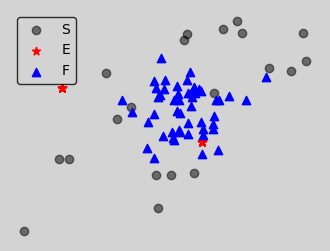

In [7]:
plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))
plot_UAV_FLPO_3D(START_locs, END_locs, F_base)


### Annealing loop implementation
Warning: Use $\beta >= 1e-3$, as the free energy approximation is poor for $\beta < 5e-4$ with torch.float32 datatype.

In [9]:
beta_min = 1e-3 
beta_max = 1e5 
beta_grow = 3 
optim_iters = 100 
optim_step = 0.05 # 0.1 for gd0, sampling_gd, use < 0.01 for the other two optimizers 
optim_name = 'sampling_gradient_descent' 
tol = 1e-2 

Y_arr, b_arr, F_arr = anneal( 
        F_base, START_locs, END_locs, vrp_net, lse_net, optim_iters, optim_step, 
        beta_min, beta_max, beta_grow, D_max_range=D_max_range, tol=tol, 
        optimizer_name=optim_name, n_path_samples=100, allowPrint=True 
    ) 


n_drones:100	num_facilities:20	dim_:2
beta: 1.0000e-03	FreeE: -4614.6851	Grad: 8.3714e-02
n_drones:100	num_facilities:20	dim_:2
beta: 3.0000e-03	FreeE: -1537.9491	Grad: 1.6663e-02
n_drones:100	num_facilities:20	dim_:2
beta: 9.0000e-03	FreeE: -512.3651	Grad: 1.2424e-02
n_drones:100	num_facilities:20	dim_:2
beta: 2.7000e-02	FreeE: -170.5056	Grad: 1.2310e-02
n_drones:100	num_facilities:20	dim_:2
beta: 8.1000e-02	FreeE: -56.5538	Grad: 9.9555e-03
n_drones:100	num_facilities:20	dim_:2
beta: 2.4300e-01	FreeE: -18.5701	Grad: 9.5922e-03
n_drones:100	num_facilities:20	dim_:2
beta: 7.2900e-01	FreeE: -5.9140	Grad: 9.8724e-03
n_drones:100	num_facilities:20	dim_:2
beta: 2.1870e+00	FreeE: -1.7085	Grad: 1.5387e-02
n_drones:100	num_facilities:20	dim_:2
beta: 6.5610e+00	FreeE: -0.3499	Grad: 2.3539e-02
n_drones:100	num_facilities:20	dim_:2


KeyboardInterrupt: 

In [10]:
Y_arr[-1] 

tensor([[[0.6465, 0.5324],
         [0.2876, 0.3382],
         [0.5463, 0.5872],
         [0.4143, 0.4202],
         [0.4169, 0.4903],
         [0.2117, 0.0831],
         [0.4125, 0.4213],
         [0.4103, 0.4219],
         [0.4459, 0.5308],
         [0.4746, 0.5799],
         [0.3088, 0.3889],
         [0.2408, 0.2200],
         [0.2650, 0.2816],
         [0.4074, 0.4242],
         [0.4114, 0.4217],
         [0.3798, 0.4595],
         [0.3297, 0.4350],
         [0.3610, 0.6099],
         [0.4128, 0.4212],
         [0.2149, 0.1546]]])

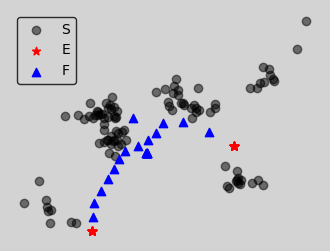

In [11]:
plot_UAV_FLPO(START_locs, END_locs, Y_arr[-1], (4,3))
plot_UAV_FLPO_3D(START_locs, END_locs, Y_arr[-1])

### Plot free energy during annealing implementation

In [12]:
# # plot free energy evolution
# plt.figure(figsize=(10,3))
# plt.plot(np.log(b_arr)/np.log(10), F_arr, marker='.')
# plt.ylabel(rf'$F$')
# plt.xlabel(rf'$\log_{{10}}\beta$')
# plt.grid()
# plt.show()

# Save an Animation

In [26]:
Animator.animate_UAV_FLPO(
    START_locs,
    END_locs,
    Y_arr,
    figuresize=(6, 5),
    interval=100,
    save_path="facility_movement_2D.gif",
)


2025-07-03 11:43:41,758 - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [13]:
Animator.animate_UAV_FLPO_3D(
        START_locs,
        END_locs,
        Y_arr,
        start_altitudes=None,
        end_altitudes=None,
        facility_heights_list=None,
        scene_title="UAV Spatial Deployment Over Time",
        output_gif="facility_movement_3D.gif",
        frame_duration=100,
        render_timeout=30,
        camera = (0.3,0.7,2.0)
    )



2025-07-03 11:06:21,633 - INFO - Rendering frame 0/12
2025-07-03 11:06:21,652 - INFO - Chromium init'ed with kwargs {}
2025-07-03 11:06:21,654 - INFO - Found chromium path: /Applications/Google Chrome.app/Contents/MacOS/Google Chrome
2025-07-03 11:06:21,655 - INFO - Temp directory created: /var/folders/sh/ndxykdmj1q9cwr2kpvkvcbs80000gn/T/tmpunqcl7gn.
2025-07-03 11:06:21,656 - INFO - Opening browser.
2025-07-03 11:06:21,657 - INFO - Temp directory created: /var/folders/sh/ndxykdmj1q9cwr2kpvkvcbs80000gn/T/tmp5gsn90jq.
2025-07-03 11:06:21,657 - INFO - Temporary directory at: /var/folders/sh/ndxykdmj1q9cwr2kpvkvcbs80000gn/T/tmp5gsn90jq
2025-07-03 11:06:22,691 - INFO - Conforming 1 to file:///var/folders/sh/ndxykdmj1q9cwr2kpvkvcbs80000gn/T/tmpunqcl7gn/index.html
2025-07-03 11:06:22,694 - INFO - Waiting on all navigates
2025-07-03 11:06:23,310 - INFO - All navigates done, putting them all in queue.
2025-07-03 11:06:23,312 - INFO - Getting tab from queue (has 1)
2025-07-03 11:06:23,312 - INFO

'facility_movement_3D.gif'

### Compare with original FLPO solution

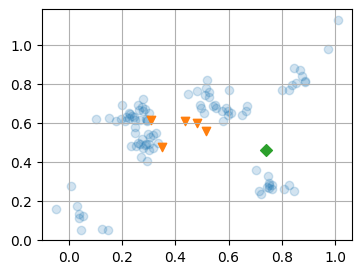

In [31]:
import classFLPO as cf
importlib.reload(cf)

flpo_filename = 'numpy_FLPO_data/numpy_FLPO_data'
flpo = cf.FLPO(flpo_filename, plotFLPO=True, disType='sqeuclidean', selfHop=True)

In [33]:
Y0 = flpo.facilityLocations
init_guess = Y0.flatten()

In [34]:
cost, params, time = flpo.optimize_D(init_guess, beta=1e5, method='trust-constr', method_options={'verbose':1})

`gtol` termination condition is satisfied.
Number of iterations: 40, function evaluations: 330, CG iterations: 90, optimality: 3.82e-09, constraint violation: 0.00e+00, execution time: 0.13 s.


2025-07-03 11:12:11,564 - INFO - TemporaryDirectory.cleanup() worked.
2025-07-03 11:12:11,565 - INFO - shutil.rmtree worked.
2025-07-03 11:12:11,565 - INFO - TemporaryDirectory.cleanup() worked.
2025-07-03 11:12:11,566 - INFO - shutil.rmtree worked.


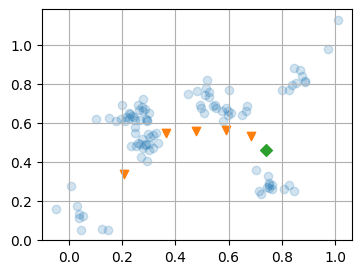

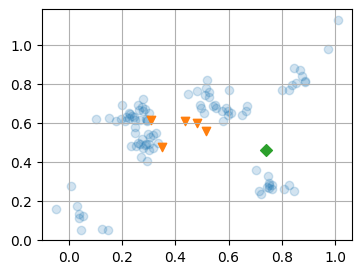

In [35]:
flpo.facilityLocations = params.reshape(-1,2)
flpo.plotFLPO()
ext_facilities = F_base.cpu().squeeze().detach().numpy()
flpo.facilityLocations = ext_facilities
flpo.plotFLPO()

In [36]:
beta_o = beta_min
params_o = Y0.flatten()
b_arr_o = []
F_arr_o = []

while beta_o <= beta_max:
    cost_o, params_o, time = flpo.optimize_D(params_o, beta=beta_o, method='trust-constr', method_options={'verbose':0})
    b_arr_o.append(beta_o)
    F_arr_o.append(cost_o)

    params_o = params_o + 0.01*np.random.uniform(-1,1,params_o.shape)
    beta_o = beta_grow * beta_o

    print(
        f"beta: {beta_o:.4e}\tFreeE: {cost_o:.4f}"
    )

/Users/dhananjaytiwari/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.



beta: 3.0000e-03	FreeE: -8270.1048
beta: 9.0000e-03	FreeE: -2756.5921
beta: 2.7000e-02	FreeE: -918.7545
beta: 8.1000e-02	FreeE: -306.1419
beta: 2.4300e-01	FreeE: -101.9378
beta: 7.2900e-01	FreeE: -33.8697
beta: 2.1870e+00	FreeE: -11.1804
beta: 6.5610e+00	FreeE: -3.6172
beta: 1.9683e+01	FreeE: -1.0962
beta: 5.9049e+01	FreeE: -0.2559
beta: 1.7715e+02	FreeE: 0.0101
beta: 5.3144e+02	FreeE: 0.0670
beta: 1.5943e+03	FreeE: 0.0742


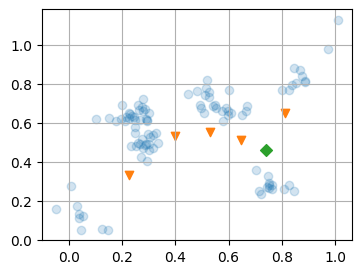

In [37]:
flpo.facilityLocations = params_o.reshape(-1,2)
flpo.plotFLPO()

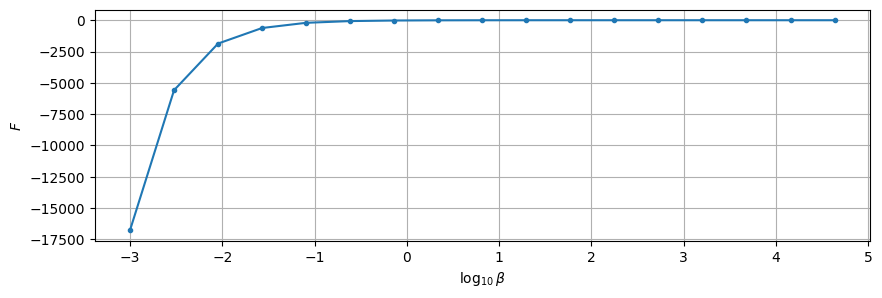

In [74]:
# plot free energy evolution
plt.figure(figsize=(10,3))
plt.plot(np.log(b_arr_o)/np.log(10), F_arr_o, marker='.')
plt.ylabel(rf'$F$')
plt.xlabel(rf'$\log_{{10}}\beta$')
plt.grid()
plt.show()